In [2]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import matplotlib
import pylab as pl
from keras.callbacks import ModelCheckpoint

2023-02-28 01:54:05.475462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
A = -0.8
B = 0.16
C = 0.1

dt = 1e-4

# u = [[0]*100 + [.01]*200 + [.02]*200 + [-.01]*200 + [0]*100, [-0.015]*200 + [-.01]*200 + [.01]*200 + [-.01]*200]
u = 1
x = 0

y_arr = []

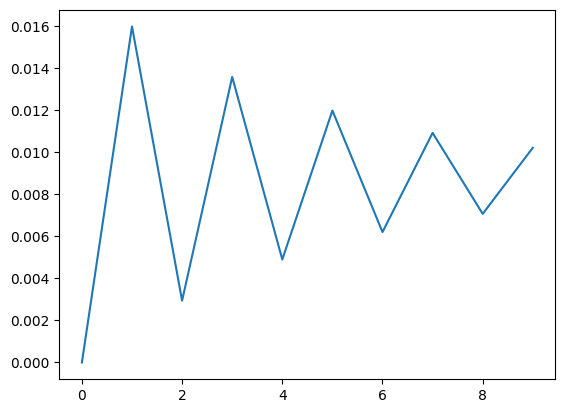

In [3]:
for t in range(10):
    y = C * x

    u = 1 - y

    x = A * x + B * u

    y_arr.append(y)

plt.plot(y_arr)
plt.show()

In [4]:
k_p = 0.12
k_i = 0.06
k_d = 0.007

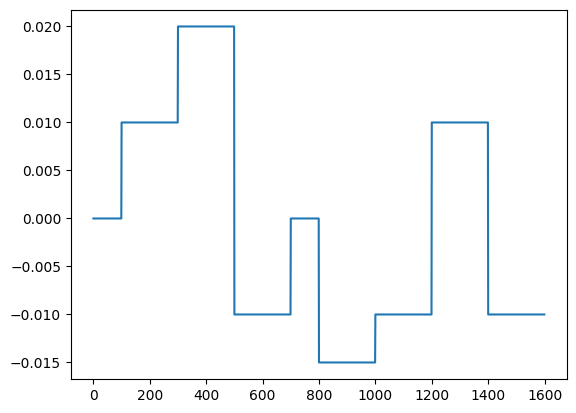

In [5]:
z_ref = [[0]*100 + [.01]*200 + [.02]*200 + [-.01]*200 + [0]*100 + [-0.015]*200 + [-.01]*200 + [.01]*200 + [-.01]*200]
z_ref = np.array(z_ref).reshape(1600,)
plt.plot(z_ref)

In [6]:
e_int = 0
e_past = 0
z_t_arr = []

u = np.zeros((u.shape[0]),)
x = 0

for i in range(z_ref.shape[0]):
    z_t = C * x

    e = z_ref[i] - z_t
    e_diff = e - e_past

    u[i] = e * k_p + e_int * k_i + e_diff * k_d
    x = A * x + B * u[i]

    e_int += e
    e_past = e

    z_t_arr.append(z_t)

z_t_arr = np.array(z_t_arr)
print(z_t_arr.shape)
plt.plot(z_t_arr)
plt.plot(z_ref)
plt.show()

AttributeError: 'float' object has no attribute 'shape'

### Reinforcement Learning

In [4]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [38]:
#Dimension of State Space
num_states = 4
print("Size of State Space ->  {}".format(num_states))
num_actions = 1
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = 0.2
lower_bound = -0.2

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  4
Size of Action Space ->  1
Max Value of Action ->  0.2
Min Value of Action ->  -0.2


In [39]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [40]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states))
    out = layers.Dense(256, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(inputs)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(128, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(64, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(out)
    outputs = layers.Dense(1, activation="tanh")(out)

    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(state_input)
    state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(128, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(concat)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(64, activation="selu", kernel_initializer=keras.initializers.RandomNormal(stddev=0.01))(out)
    outputs = layers.Dense(1, activation="tanh")(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [41]:
std_dev = 0.001
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 10
# Discount factor for future rewards
gamma = 0.98
# Used to update target networks
tau = 0.01

buffer = Buffer(5000, 32)

In [42]:
# Length between z_t and z_ref
def length_z(z_ref, z_t):
    return abs(z_ref - z_t)

# loss function
def loss(z_ref, z_t):
    return np.power(z_ref - z_t, 2)

# reward function
def GetReward(z_ref, state):
    loss_value = loss(z_ref, state[1])
    r = -np.log(loss_value) - np.power(state[0], 2) #* np.exp(loss_value)
    return r

# generate z_ref command
def z_ref_generate():
    coeff = []
    values = []
    amount = np.random.randint(3, 15)

    for i in range(amount):
        coeff.append(np.random.randint(100,200))
        values.append(np.random.uniform(-0.02,0.02))

    coeff = np.array(coeff)
    values = np.array(values)

    z_ref = []
    for i in range(amount):
        z_ref += [values[i]]*coeff[i]

    return z_ref

# x function
def x_calculate(x, u, A, B):
    return A * x + B * u

# transition function from S state to S' state
def transition(x, u, C, z_ref):
    z_t = C * x
    return (length_z(z_ref, z_t), z_t, z_ref, u)

In [43]:
def policy(state, noise_object):
    # error = loss(target_state, state)
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

Episode * 0 * Avg Reward is ==> 2131.9438916659483 z_ref = -1.9510291949534053 and z_arr = 592.5600221722416


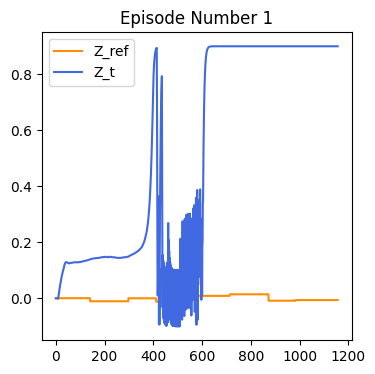

Episode * 1 * Avg Reward is ==> 737.2485703306455 z_ref = -1.7861026644194933 and z_arr = 980.2800000000003
Episode * 2 * Avg Reward is ==> 386.8763129569999 z_ref = -4.015389168200751 and z_arr = -530.8200000000002
Episode * 3 * Avg Reward is ==> 114.5746607435457 z_ref = 3.4110407296386285 and z_arr = -1037.88
Episode * 4 * Avg Reward is ==> -53.23804166037364 z_ref = 5.797153951057989 and z_arr = -1056.7800000000002
Episode * 5 * Avg Reward is ==> -98.19548490169636 z_ref = -2.4086308121642173 and z_arr = -503.28000000000014
Episode * 6 * Avg Reward is ==> -135.40549210972446 z_ref = -2.5276007364339192 and z_arr = -1054.6600474920767
Episode * 7 * Avg Reward is ==> -113.35499571653172 z_ref = 4.614552955728031 and z_arr = -688.1321053374679
Episode * 8 * Avg Reward is ==> -139.2851329629603 z_ref = -8.765614714661261 and z_arr = -1259.7311725817015
Episode * 9 * Avg Reward is ==> -118.38630615378631 z_ref = 5.894719060978197 and z_arr = -502.4692664965744
Episode * 10 * Avg Reward 

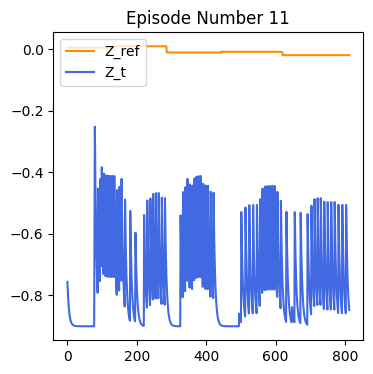

Episode * 11 * Avg Reward is ==> -185.94683782270158 z_ref = 7.115043843955156 and z_arr = -942.605859806047
Episode * 12 * Avg Reward is ==> -162.52708974993422 z_ref = 1.9607829715829577 and z_arr = 268.0290167828608
Episode * 13 * Avg Reward is ==> -144.77898188380897 z_ref = 1.8270794368495313 and z_arr = 802.9800000000002
Episode * 14 * Avg Reward is ==> 314.865033295723 z_ref = 11.027437958266635 and z_arr = 42.3926736715178
Episode * 15 * Avg Reward is ==> 388.9301270244052 z_ref = -3.7738700576799147 and z_arr = 500.5394785073631
Episode * 16 * Avg Reward is ==> 505.8819242927046 z_ref = 6.753890543412304 and z_arr = 1084.8421743726885
Episode * 17 * Avg Reward is ==> 605.9234328700097 z_ref = -0.8187223020881738 and z_arr = 641.9630132444279
Episode * 18 * Avg Reward is ==> 815.900464404771 z_ref = -6.7213482466308365 and z_arr = 1052.5033568883637
Episode * 19 * Avg Reward is ==> 888.565133936265 z_ref = -8.095335871828517 and z_arr = 463.40584483579266
Episode * 20 * Avg Rew

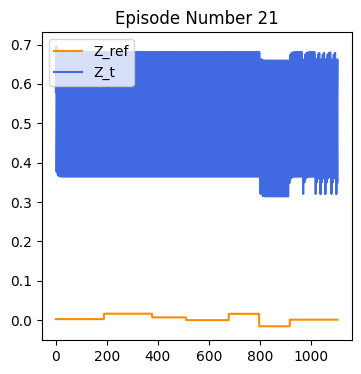

Episode * 21 * Avg Reward is ==> 1025.2781269436625 z_ref = -3.2777864002232238 and z_arr = 441.90924394974587
Episode * 22 * Avg Reward is ==> 1159.229302819089 z_ref = -6.026487566851216 and z_arr = 482.55545829735087
Episode * 23 * Avg Reward is ==> 1469.6858094279487 z_ref = 1.5510474440151283 and z_arr = 954.5416086584773
Episode * 24 * Avg Reward is ==> 1334.7969407566736 z_ref = 8.562957119755065 and z_arr = 792.3126805881732
Episode * 25 * Avg Reward is ==> 1500.173682282079 z_ref = -0.057488594918753244 and z_arr = 631.9232951916076
Episode * 26 * Avg Reward is ==> 1599.817659415567 z_ref = 5.552463429549784 and z_arr = 552.0237253744206
Episode * 27 * Avg Reward is ==> 1801.2460928658984 z_ref = 6.60984528180904 and z_arr = 902.0321951219514
Episode * 28 * Avg Reward is ==> 1924.945389275747 z_ref = -9.723596539750124 and z_arr = 774.8743681742164
Episode * 29 * Avg Reward is ==> 2007.9884758417288 z_ref = -3.448630276756181 and z_arr = 422.31428457015886
Episode * 30 * Avg R

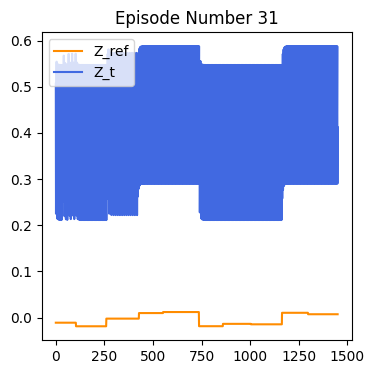

Episode * 31 * Avg Reward is ==> 2301.89898276088 z_ref = 2.0438157411805884 and z_arr = 686.4553843680058
Episode * 32 * Avg Reward is ==> 2442.741393472189 z_ref = -5.94979713408137 and z_arr = 625.391042601361
Episode * 33 * Avg Reward is ==> 2314.718389288294 z_ref = 2.4429445682149846 and z_arr = 285.6838691902991
Episode * 34 * Avg Reward is ==> 2394.720791834459 z_ref = 4.9912179709877105 and z_arr = 749.9614963276224
Episode * 35 * Avg Reward is ==> 2330.759700016501 z_ref = -3.944154192701723 and z_arr = 293.65044044854096
Episode * 36 * Avg Reward is ==> 2459.211034373385 z_ref = 5.986030740847664 and z_arr = 620.3938208061426
Episode * 37 * Avg Reward is ==> 2513.9228761092354 z_ref = -9.19926088736552 and z_arr = 650.7351528289231
Episode * 38 * Avg Reward is ==> 2642.7767321296133 z_ref = -4.818396976617134 and z_arr = 698.1369723124205
Episode * 39 * Avg Reward is ==> 2909.214654040902 z_ref = -6.722835948346255 and z_arr = 600.2541076298417
Episode * 40 * Avg Reward is =

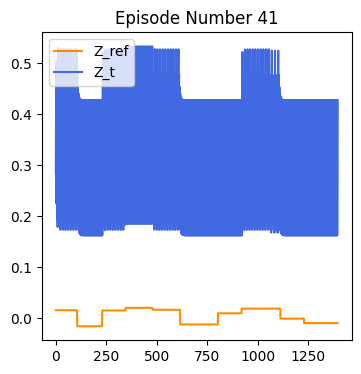

Episode * 41 * Avg Reward is ==> 3242.5056356561468 z_ref = 3.9723628490979657 and z_arr = 631.929836065574
Episode * 42 * Avg Reward is ==> 3458.312151689525 z_ref = 0.14040392341773256 and z_arr = 589.2521311475413
Episode * 43 * Avg Reward is ==> 3760.064875740942 z_ref = 9.13529757345774 and z_arr = 517.8422950819674
Episode * 44 * Avg Reward is ==> 3655.139212240174 z_ref = 1.4877992775172169 and z_arr = 276.0078688524591
Episode * 45 * Avg Reward is ==> 3728.8249337438347 z_ref = -0.559410564965682 and z_arr = 265.3200000000001
Episode * 46 * Avg Reward is ==> 3655.921538964098 z_ref = -3.722196075129692 and z_arr = 292.2078688524591
Episode * 47 * Avg Reward is ==> 3769.566339586484 z_ref = -0.4931830921278664 and z_arr = 578.829836065574
Episode * 48 * Avg Reward is ==> 3720.120726305407 z_ref = -12.468469474298526 and z_arr = 473.7422950819674
Episode * 49 * Avg Reward is ==> 3397.5341136075576 z_ref = -1.5921857464081777 and z_arr = 131.27016393442628
Episode * 50 * Avg Rewar

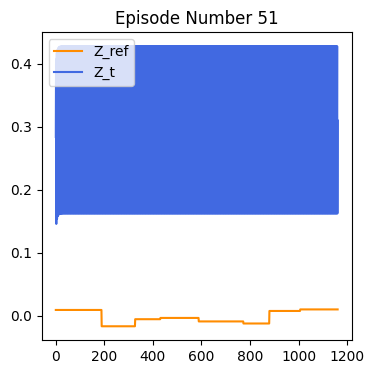

Episode * 51 * Avg Reward is ==> 3023.4050710685483 z_ref = -10.746931812134505 and z_arr = 237.0422950819673
Episode * 52 * Avg Reward is ==> 2998.8330668953977 z_ref = 1.0265708973982002 and z_arr = 557.2800000000002
Episode * 53 * Avg Reward is ==> 2693.7314643576487 z_ref = 6.827639579586661 and z_arr = 147.94229508196727
Episode * 54 * Avg Reward is ==> 2653.46222270409 z_ref = 4.580229123962778 and z_arr = 223.38000000000008
Episode * 55 * Avg Reward is ==> 2958.5440528313875 z_ref = -5.707865545036199 and z_arr = 643.2521311475411
Episode * 56 * Avg Reward is ==> 2895.562241039422 z_ref = 5.850510601050447 and z_arr = 206.2800000000001
Episode * 57 * Avg Reward is ==> 2535.749698366854 z_ref = 5.320300688781511 and z_arr = 133.92000000000004
Episode * 58 * Avg Reward is ==> 2368.418643002 z_ref = 3.0832161439557595 and z_arr = 253.98000000000008
Episode * 59 * Avg Reward is ==> 2461.1164388014577 z_ref = 4.2291250559833236 and z_arr = 239.5800000000001
Episode * 60 * Avg Reward 

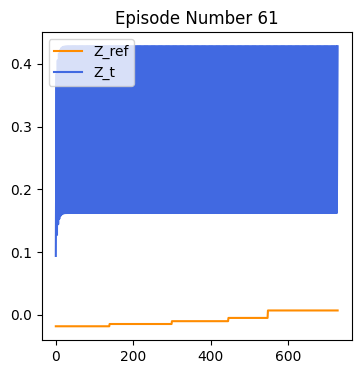

Episode * 61 * Avg Reward is ==> 2417.087212565956 z_ref = -1.344795923743093 and z_arr = 306.55770491803287
Episode * 62 * Avg Reward is ==> 2418.8720983415405 z_ref = -5.7239180467661015 and z_arr = 566.8200000000003


KeyboardInterrupt: 

In [44]:
# actor_model.load_weights("../weights/nn_actor.h5")
# critic_model.load_weights("../weights/nn_critic.h5")

# target_actor.load_weights("../weights/nn_target_actor.h5")
# target_critic.load_weights("../weights/nn_target_critic.h5")

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []
# Define matrixes
A = 0.8
B = 0.9
C = 1
# Define start value x
x = 0
u = 0


total_episodes = 500
for ep in range(total_episodes):

    z_ref = z_ref_generate()
    z_ref = np.array(z_ref)
    z_arr = []

    x = x_calculate(x, u, A, B)
    z_t = C * x

    prev_state = (length_z(z_ref[0], z_t), z_t, z_ref[0], u)
    episodic_reward = 0

    t = 0
    dt = 1

    for step in range(z_ref.shape[0]):
    # while percent(z_ref[step], state)
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        # prev_state = z_ref[step]

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        # z_ref = tf.expand_dims(tf.convert_to_tensor(), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        x = x_calculate(x, float(action[0]), A, B)
        state = transition(x, float(action[0]), C, z_ref[t])
        # state = float(action[0])
        reward = GetReward(z_ref[t], state)
        z_arr.append(state[1])

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        t += dt

        prev_state = state

    ep_reward_list.append(episodic_reward)
    # Mean of last 10 episodes
    avg_reward = np.mean(ep_reward_list[-10:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward),
        "z_ref = {} and z_arr = {}".format(np.sum(z_ref), np.sum(np.array(z_arr))))
    avg_reward_list.append(avg_reward)

    if ep % 10 == 0:
        fig, ax = plt.subplots(figsize=(4, 4))
        # ax.axis('equal')
        title = "{} {}".format("Episode Number", ep+1)

        ax.plot(z_ref, color = 'darkorange', label = 'Z_ref')
        ax.plot(z_arr, color = 'royalblue', label = 'Z_t')

        ax.legend(loc = 'upper left')
        plt.title(title)
        plt.show()

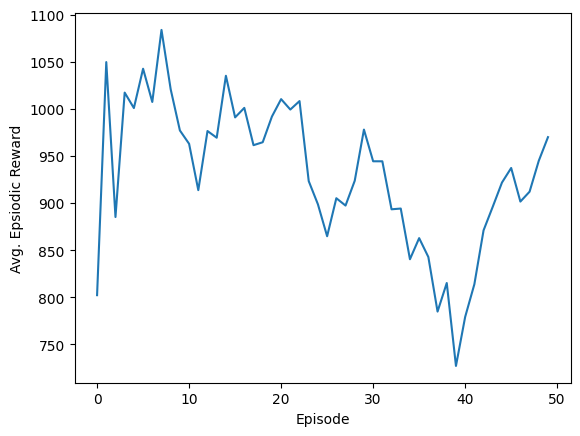

In [11]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [107]:
# Save the weights
actor_model.save_weights("../weights/nn_actor.h5")
critic_model.save_weights("../weights/nn_critic.h5")

target_actor.save_weights("../weights/nn_target_actor.h5")
target_critic.save_weights("../weights/nn_target_critic.h5")

### Supervised Learning